## Neural Networks (a.a. 2023-2024)
### Lab session 3: Convolutional neural networks

Contents:
1. Downloading and preprocessing data with `torchvision.transforms`.
2. Understanding batch normalization and dropout.
3. Building a simple CNN and training with [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/).

In [ ]:
# Install the required libraries (they will be discussed later on in the notebook).
%pip install torchmetrics lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 32.1 MB/s eta 0:00:00


### Step 1 - Loading the dataset

In [ ]:
import torch
import torchvision

Before this section, take a moment to read how datasets and data loaders are implemented in PyTorch: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html. In a nutshell, a `Dataset` object is an iterable over the elements in the dataset, while the data loader provides methods to batch the data and shuffle it.

In [ ]:
# KMNIST is a drop-in replacement for MNIST (same number of points, same dimensionality, same number of classes)
# http://codh.rois.ac.jp/kmnist/index.html.en
train_data = torchvision.datasets.KMNIST('kmnist', download=True)

100%|██████████| 18165135/18165135 [00:22<00:00, 822357.75it/s]


Extracting kmnist/KMNIST/raw/train-images-idx3-ubyte.gz to kmnist/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 132951.54it/s]


Extracting kmnist/KMNIST/raw/train-labels-idx1-ubyte.gz to kmnist/KMNIST/raw



100%|██████████| 3041136/3041136 [00:05<00:00, 594479.92it/s]


Extracting kmnist/KMNIST/raw/t10k-images-idx3-ubyte.gz to kmnist/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 5372738.67it/s]

Extracting kmnist/KMNIST/raw/t10k-labels-idx1-ubyte.gz to kmnist/KMNIST/raw



In [ ]:
for x, y in train_data:
  # Each element of the dataset is a greyscale 28x28 image (PIL image).
  # The output is a label in [0, ..., 9].
  print(type(x))
  print(y)
  break

<class 'PIL.Image.Image'>
8


In [ ]:
x

### Step 2 - Transformations

In [ ]:
import torchvision.transforms.v2 as T

In [ ]:
import matplotlib.pyplot as plt

Transformations are used to preprocess or augment images. Read more about their usage here: https://pytorch.org/vision/0.15/transforms.html. Like most objects in PyTorch, they come in object-oriented format or in a functional format. The v2 module has a new, updated set of transforms which are backward-compatible with the old module.

In [ ]:
# This converts a PIL image into a PyTorch tensor of float32 values in the range [0, 1].
# Note that this is deprecated (will be removed soon). The new version should be: v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]).
tran = T.ToTensor()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


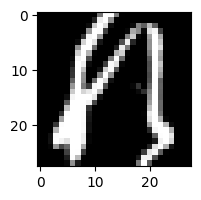

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(tran(x).numpy()[0], cmap='gray')

In [ ]:
# Another example of transformation: this one is an augmentation.
tran = T.RandomRotation(60)

In [ ]:
tran(x)

In [ ]:
# Transformations can be composed in many ways, including sequential composition,
# random choices, etc. For sequential composition, the order is important, also for efficiency.
train_transforms = T.Compose([
    T.RandomRotation(10),
    T.ToTensor()
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
# We can specify a set of transformations to be applied every time the dataset is iterated over.
# Importantly, these are not applied once but once per epoch.
train_data = torchvision.datasets.KMNIST('kmnist',
                                         transform=train_transforms)

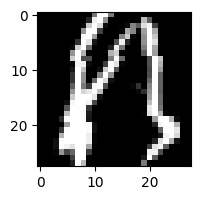

In [ ]:
for x, y in train_data:
  plt.figure(figsize=(2,2))
  plt.imshow(x.numpy()[0], cmap='gray')
  break

In [ ]:
# For the test data, we avoid any stochastic transformation.
test_data = torchvision.datasets.KMNIST('kmnist',
                                        train=False,
                                        transform=T.ToTensor())

In [ ]:
# The data loader can be used to batch together images. Shuffle=True will shuffle
# the data before every epoch.
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=128, shuffle=True
)

torch.Size([128, 1, 28, 28])
torch.Size([128])


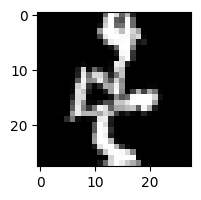

In [ ]:
for x, y in train_loader:
  print(x.shape)
  print(y.shape)
  # Note: the figure is different each time you run this code, because of shuffling.
  plt.figure(figsize=(2,2))
  plt.imshow(x[0,0].numpy(), cmap='gray')
  break

In [ ]:
# We remove the shuffling in the test data.
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128,
                               shuffle=False)

### Step 3 - Playing with layers

In [ ]:
from torch import nn

Before moving on, take a look at all the layers in PyTorch: https://pytorch.org/docs/stable/nn.html

#### 3a: Convolutional layers

In [ ]:
# Hint: play a bit here with kernel size, padding, stride, dilation, etc.
# Try to predict what happens to the output shape before running the command below.
conv = nn.Conv2d(1, 5, kernel_size=3, padding=2, stride=2, dilation=2)

In [ ]:
conv(x).shape

torch.Size([128, 5, 14, 14])

In [ ]:
# parameters() returns a generator over the parameters (trainable tensors).
# named_parameters() is identical, except that it returns a name for each parameter.
for n, p in conv.named_parameters():
  print(n)
  print(p.shape)

weight
torch.Size([5, 1, 3, 3])
bias
torch.Size([5])


#### 3b: Pooling layers

In [ ]:
# Standard max-pooling
maxpool = nn.MaxPool2d(2)
print(maxpool(conv(x)).shape)

torch.Size([128, 5, 7, 7])


In [ ]:
# Global average pooling: the adaptive version of max-pooling takes as input the desired output shape,
# and adapts the pooling window to match this shape.
nn.AdaptiveAvgPool2d(2)(x).shape

torch.Size([128, 1, 2, 2])

#### 3c: Dropout

In [ ]:
# The input is the probability of masking an element.
drop = nn.Dropout(0.25)

In [ ]:
s = torch.randn((3, 2))
print(s)

tensor([[ 0.9088, -0.5450],
        [-0.0902,  1.2619],
        [ 0.9195,  1.6547]])


In [ ]:
# Set if the layer should work in "training mode" (drop values), or "evaluation mode" (do nothing).
drop.train()
# drop.eval()

Dropout(p=0.25, inplace=False)

In [ ]:
# Note that unmasked values are multiplied by 1/(1-p).
# Uncomment eval() above and see what happens.
drop(s)

tensor([[ 0.0000, -0.7266],
        [-0.1203,  1.6825],
        [ 1.2260,  2.2063]])

#### 3d: Batch normalization

In [ ]:
bn = nn.BatchNorm2d(5)

In [ ]:
# The parameters are the scale and shift factors applied to the normalized inputs (alpha and beta in the slides).
for n, p in bn.named_parameters():
  print(n)
  print(p)

weight
Parameter containing:
tensor([1., 1., 1., 1., 1.], requires_grad=True)
bias
Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)


In [ ]:
# "buffers" in PyTorch are untrained tensors. In this case, the running mean and the running variance of the model.
for n, b in bn.named_buffers():
  print(n)
  print(b)

running_mean
tensor([0., 0., 0., 0., 0.])
running_var
tensor([1., 1., 1., 1., 1.])
num_batches_tracked
tensor(0)


In [ ]:
# bn.eval()

In [ ]:
o = bn(conv(x))

In [ ]:
# Check: mean is basically 0 per channel. The buffers have been modified.
# Check 2: uncomment eval and run again. What happens?
o.mean([0,2,3])

tensor([ 8.5245e-08,  2.4043e-09,  6.8234e-08, -5.0862e-08, -1.0644e-09],
       grad_fn=<MeanBackward1>)

### Step 4 - Building the model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
      super().__init__()
      # This is a simple model composed of 3 convolutional blocks (Conv2d - BatchNorm2d - MaxPool),
      # followed by global average pooling and one or more fully-connected layers.

      self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
      self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv3 = nn.Conv2d(64, 128, 5, padding=2)

      self.bn1 = nn.BatchNorm2d(32)
      self.bn2 = nn.BatchNorm2d(64)
      self.bn3 = nn.BatchNorm2d(128)

      self.relu = nn.ReLU()
      # Functional alternative: nn.functional.relu

      self.maxpool = nn.MaxPool2d(2)
      self.global_pool = nn.AdaptiveAvgPool2d(1)

      self.dense1 = nn.Linear(128, 256)
      self.dense2 = nn.Linear(256, 10)

      self.drop = nn.Dropout(0.3)

    def forward(self, x):
      x = self.relu(self.bn1(self.conv1(x))) # (32, 28, 28)
      x = self.maxpool(x)                    # (32, 14, 14)
      x = self.relu(self.bn2(self.conv2(x))) # (64, 14, 14)
      x = self.maxpool(x)                    # (64, 7, 7)
      x = self.relu(self.bn3(self.conv3(x))) # (128, 7, 7)
      x = self.maxpool(x)                    # (128, 3, 3)
      x = self.global_pool(x)                # (128, 1, 1)
      x = self.drop(
          self.relu(self.dense1(x[:, :, 0, 0]))) # (256,)
      return self.dense2(x)                      # (10,)


In [ ]:
cnn = SimpleCNN()

In [ ]:
# Sanity check
cnn(x).shape

torch.Size([128, 10])

In [ ]:
for n, p in cnn.named_parameters():
  print(p.shape)

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([128, 64, 5, 5])
torch.Size([128])
torch.Size([32])
torch.Size([32])
torch.Size([64])
torch.Size([64])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [ ]:
# If you do not see a GPU here, enable it from Runtime >> Change Runtime Type and re-run the entire notebook.
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [ ]:
# Every tensor, object, etc., "lives" in a certain device. To perform an operation,
# all objects involved should be on the same device.
x.device

device(type='cpu')

In [ ]:
# Move objects between devices.
x = x.to('cuda')

#### Interlude: compute the accuracy

In [ ]:
import torchmetrics

Read the quick-start here: https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html

In [ ]:
acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)

In [ ]:
# Important: to run on GPU, everything should be there!
cnn = cnn.to('cuda')
acc = acc.to('cuda')

In [ ]:
cnn.eval()
for xb, yb in test_loader:
  xb, yb = xb.to('cuda'), yb.to('cuda')
  ypred = cnn(xb) # (batch_size, 10)
  # The values of the accuracy for each mini-batch are accumulated inside the object.
  acc(ypred.argmax(1), yb)

In [ ]:
# Compute the accuracy over the entire dataset.
acc.compute()

tensor(0.1000, device='cuda:0')

In [ ]:
# Reset to remove all values stored inside.
acc.reset()

### Step 5 - Training the model

In [ ]:
import pytorch_lightning as ptl

Before proceeding, read the 15-minutes quick-start here: https://lightning.ai/docs/pytorch/stable/starter/introduction.html

In [ ]:
class PTLWrapper(ptl.LightningModule):
    def __init__(self, cnn):
      super().__init__()
      self.cnn = cnn
      self.acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
      self.loss = torch.nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
      # This is a single training step, which returns the loss.
      # Note that we do not need to worry about devices, train/eval, etc.
      xb, yb = batch
      ypred = self.cnn(xb)
      loss = self.loss(ypred, yb)
      # We can log multiple values, deciding whether we want them logged externally or shown in the progress bar.
      self.log("train_loss", loss, prog_bar=True, logger=False)
      return loss

    def validation_step(self, batch, batch_idx):
      # After each training epoch, if a validation set is provided PTL runs an epoch over it.
      # We can use this to store any interesting metric (in this case, the accuracy).
      xb, yb = batch
      ypred = self.cnn(xb)
      self.acc(ypred, yb)
      self.log('val_accuracy', self.acc, on_step=False, on_epoch=True, prog_bar=True, logger=False)

    def configure_optimizers(self):
      return torch.optim.Adam(self.cnn.parameters())

In [ ]:
cnn = SimpleCNN()
ptl_wrapper = PTLWrapper(cnn)

In [ ]:
# Callbacks add functionalities to the training loop (in this case, an early stopping procedure).
es_callback = ptl.callbacks.EarlyStopping('val_accuracy', mode='max', check_on_train_epoch_end=False)

In [ ]:
trainer = ptl.Trainer(accelerator='gpu', devices=1, callbacks=[es_callback], max_epochs=10_000)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(ptl_wrapper, train_dataloaders=train_loader,
            val_dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type               | Params
--------------------------------------------
0 | cnn  | SimpleCNN          | 293 K 
1 | acc  | MulticlassAccuracy | 0     
2 | loss | CrossEntropyLoss   | 0     
--------------------------------------------
293 K     Trainable params
0         Non-trainable params
293 K     Total params
1.172     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

**Exercises**:

1. See the [full list of transforms](https://pytorch.org/vision/stable/transforms.html) available in torchvision: try to create a more complex augmentation pipeline based on `RandomChoice`, `RandomOrder`, or `RandomApply`.
2. Try a more complex model with different layers, including other activation functions (e.g., GELU), different normalizations (e.g., layer normalization), or spatial dropout procedures. You can also try adding residual connections (you will probably need to modify the hyper-parameters).
3. We have only scratched the surface of PyTorch Lightning. For some simple additional experiments, try:
  * [Decouple the hyper-parameters](https://lightning.ai/docs/pytorch/2.1.2/common/lightning_module.html#save-hyperparameters) of the model, so that you can initialize models with [many different configurations](https://lightning.ai/docs/pytorch/stable/common/hyperparameters.html). Try making the number of layers or the number of blocks additional hyper-parameters.
  * Try adding more callbacks, such as a [learning rate finder](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.LearningRateFinder.html#lightning.pytorch.callbacks.LearningRateFinder) or a [checkpoint storer](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.ModelCheckpoint.html#lightning.pytorch.callbacks.ModelCheckpoint).
  * Connect an external logger to visualize the training process, e.g., [Weights & Biases](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.wandb.html#module-lightning.pytorch.loggers.wandb). Use this to log as much values as possible during training.
  * Depending on the hardware, try to [modify the precision](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.plugins.precision.HalfPrecision.html#lightning.pytorch.plugins.precision.HalfPrecision) of training / inference to see what happens (e.g., down to 16 bits per value).
